# Setup

In [41]:
library(ggplot2)
library(cowplot)
library(ranger)
library(Metrics)
library(latex2exp)
library(reshape2)
library(akima)
library(pander)


# Generate Model

Following is an example of how to generate the prediction model using the Random Forest Model with AIWC metrics and experimental runtimes of the Extended Benchmark Suite. 

In [1]:
load("./data/intermediate/full_dat.Rda")

#manually typecast integer variables
int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
num.inds <- lapply(full_dat, is.numeric)
num.inds <- as.logical(num.inds)

for (i in seq(along = num.inds)){
            feature.name = names(full_dat[i])
            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, full_dat[i] <- scale(full_dat[i]))
                                } #end i loop

#use 20% of data for training
sampled_indices <- sample(seq_len(nrow(full_dat)), size = round(nrow(full_dat)*0.2))
train_dat <- full_dat[sampled_indices, ]
test_dat <- full_dat[-sampled_indices, ]

#remove certain variables unavailable during real-world training
train_dat = subset(train_dat, select = -size)
train_dat = subset(train_dat, select = -application)
train_dat = subset(train_dat, select = -kernel)
train_dat = subset(train_dat, select = -total_time)

#build the model
rgd.aiwc <- ranger(log(kernel_time)~.,
                   data = train_dat,
                   num.trees = 505,
                   mtry = 30,
                   min.node.size = 9,
                   importance = "impurity",
                   splitrule = 'variance',
                   respect.unordered.factors = 'order')

#make the predictions
rgd.pred <- predict(rgd.aiwc,type='response',data=test_dat)


# Making Scheduler Predictions with the Model

This Section takes AIWC metrics and makes specific predictions.
A comparison to the experimental runtimes for the selected kernel, device and size is presented. Feel free to change the `k`, `d` and `s` variables to see changes and accuracies in the predictions. This is a prototype of what could be used in smart accelerator selections for heterogenous node scheduling. Any new data can be added by loading the new kernels AIWC metrics and selecting a device name.

In [27]:
print("Select the following to evaluate the model")
#query dataframe parameters
#names(test_dat)
#query unique kernels -- to make a prediction with the model
print("kernels:")
unique(test_dat$kernel)
#query unique devices
print("devices")
unique(test_dat$device)

k = "needle_opencl_shared_2"
d = "titanx"
s = "tiny"

y <- subset(test_dat,kernel==k&device==d&size==s)
# Note the exponent is used as the inverse to the natural logarithm which was used to add stability in the model.
p <- exp(mean(predict(rgd.aiwc,type='response',data=y)$predictions))
m <- mean(y$kernel_time)
print(paste("The mean predicted time (ms) of the ",s,k," on the ",d," is ",p," the measured time is ",m))

[1] "Select the following to evaluate the model"
[1] "kernels:"


[1] invert_mapping                 kmeansPoint                   
 [3] lud_diagonal                   lud_internal                  
 [5] lud_perimeter                  csr                           
 [7] fftRadix16Kernel               fftRadix8Kernel               
 [9] fftRadix4Kernel                fftRadix2Kernel               
[11] calc_potential_single_step_dev c_CopySrcToComponents         
[13] cl_fdwt53Kernel                srad_cuda_1                   
[15] srad_cuda_2                    kernel1                       
[17] kernel2                        acc_b_dev                     
[19] calc_alpha_dev                 calc_beta_dev                 
[21] calc_gamma_dev                 calc_xi_dev                   
[23] est_a_dev                      est_b_dev                     
[25] est_pi_dev                     init_alpha_dev                
[27] init_beta_dev                  init_ones_dev                 
[29] mvm_non_kernel_naive           mvm_trans_kernel_naive        
[31] scale_a_dev                    scale_alpha_dev               
[33] scale_b_dev                    s_dot_kernel_naive            
[35] needle_opencl_shared_1         needle_opencl_shared_2        
[37] crc32_slice8                  
37 Levels: invert_mapping kmeansPoint lud_diagonal ... crc32_slice8

[1] "devices"


[1] xeon_es-2697v2  i7-6700k        titanx          gtx1080        
 [5] gtx1080ti       k20c            k40c            knl            
 [9] fiji-furyx      hawaii-r9-290x  hawaii-r9-295x2 i5-3350        
[13] polaris-rx480   tahiti-hd7970   firepro-s9150  
15 Levels: xeon_es-2697v2 i7-6700k titanx gtx1080 gtx1080ti k20c k40c ... firepro-s9150

[1] "The mean predicted time (ms) of the  tiny needle_opencl_shared_2  on the  titanx  is  21.065532761024  the measured time is  21.1451470302862"


The remainder of the Jupyter Artefact shows how the figures and results were prepared for the [paper](https://www.researchgate.net/publication/328418090_OpenCL_Performance_Prediction_using_Architecture-Independent_Features).

# Constructing the Performance Model

The R programming language was used to analyse the data, construct the model and analyse the results. In particular, the ranger package by Wright and Ziegler was used for the development of the regression model. The ranger package provides computationally efficient implementations of the Random Forest model which performs recursive partitioning of high dimensional data.

The ranger function accepts three main parameters, each of which influences the fit of the model to the data. In optimizing the model, we searched over a range of values for each parameter including:

* num.trees, the number of trees grown in the random forest: over the range of 10 − 10, 000 by 500
* mtry, the number of features tried to possibly split within each node: ranges from 1 − 34, where 34 is the maximum number of input features available from AIWC,
* min.node.size, the minimal node size per tree: ranges from 1 − 50, where 50 is the number of observations per sample.
    
Given the size of the data set, it was not computationally viable to perform an exhaustive search of the entire 3-dimensional range of parameters. Auto-tuning to determine the suitability of these parameters has been performed by Ließ et al. to determine the optimal value of mtry given a fixed num.trees. Instead, to enable an efficient search of all variables at once, we used Flexible Global Optimization with Simulated-Annealing, in particular, the variant found in the R package optimization by Husmann, Lange and Spiegel. The simulated-annealing method both reduces the risk of getting trapped in a local minimum and is able to deal with irregular and complex parameter spaces as well as with non-continuous and sophisticated loss functions. In this setting, it is desirable to minimise the out-of-bag prediction error of the resultant fitted model, by simultaneously changing the parameters (num.trees, mtry and min.node.size). The optim_sa function allows defining the search space of interest, a starting position, the magnitude of the steps according to the relative change in temperature and the wrapper around the ranger function (which parses the 3 parameters and returns a cost function — the predicted error). It allows for an approximate global minimum to be detected with significantly fewer iterations than an exhaustive grid search.

## Full coverage of min.node.size with fixed tuning parameters: num.trees = 300 and mtry = 30.

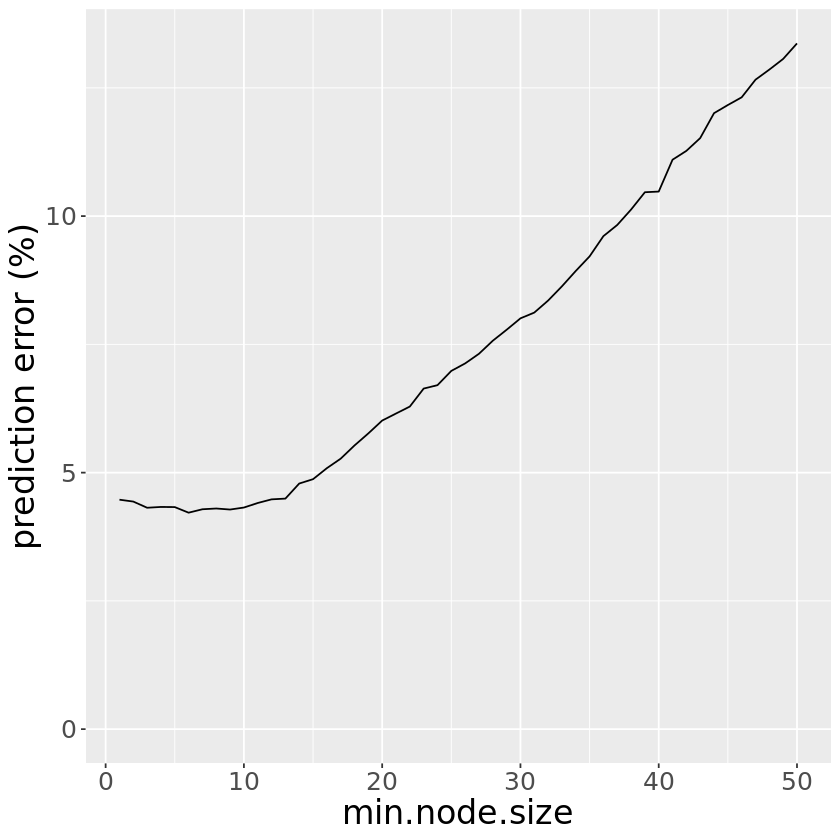

In [32]:
#this was generated in ./analysis_tools/variation_in_min.node.size.R.
#and stored the results in "./data/intermediate/variation_in_min.node.size.Rdf" as the data.frame z

load('./data/intermediate/variation_in_min.node.size.Rdf')

z$y <- z$y * 100
tplot <- ggplot(dat=z,aes(x=x,y=y)) + geom_line() + labs(x="min.node.size",y="prediction error (%)") + ylim(0,max(z$y)) + theme(text = element_text(size=20),axis.text.x = element_text(size=15),axis.text.y= element_text(size=15))
print(tplot)

This Figure shows the relationship between out-of-bag predic- tion error and min.node.size, with the num.trees = 300 and mtry = 30 parameters fixed. In general, the min.node.size has the smallest prediction error for values less than 15 and variation in prediction error is similar throughout this range. As such, the selection to fix min.node.size = 9 was made to reduce the search-space in the remainder of the tuning work. We assume conditional (relative) independence between min.node.size and the other variables.

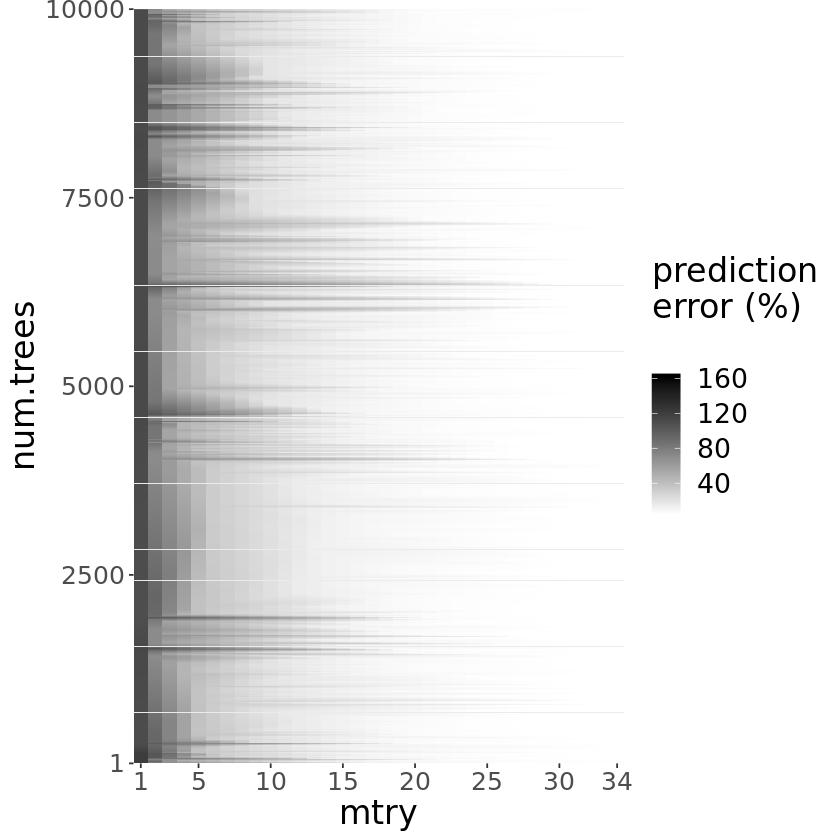

In [42]:
# this was generated by steering the starting positions of the optim_sa function to all corners of the search space and adding the log trace for each location, then randomly selecting 8 internal starting locations to sample internal detail.

x <- read.table('./data/intermediate/full_scan_random_sampled_heatmap.Rtable',header=TRUE, sep=" ")
y <- interp(x=x$mtry,
            y=x$num.trees,
            z=x$prediction.error*100,
            xo=seq(1,34),
            yo=seq(1,10000),
            duplicate="mean")
d2 <- melt(y$z, na.rm = TRUE)
names(d2) <- c("mtry", "num.trees", "prediction.error")
ggplot(data=d2, aes(x=mtry,y=num.trees,fill=prediction.error)) + geom_tile(aes(fill=prediction.error)) + scale_fill_gradient(low="white", high="black") + theme(panel.grid=element_blank()) + scale_x_continuous(breaks = c(1, 5, 10, 15, 20, 25, 30, 34), expand = c(0,0)) + scale_y_continuous(breaks=c(1,2500,5000,7500,10000), expand=c(0,0)) + labs(fill="prediction\nerror (%)\n") + theme(text = element_text(size=20), axis.text.x = element_text(size=15), axis.text.y = element_text(size=15))


This Figure shows how the prediction error of the random- forest ranger model changes over a wide range of values for the two remaining tuning parameters, mtry and num.trees. Full coverage was achieved by selecting starting locations in each of the 4 outer-most points of the search space, along with 8 random internal points — to avoid missing out on some critical internal structure. For each combination of parameter values, the optim_sa function was allowed to execute until a global minimum was found. At each step of optimization a full trace was collected, where all parameters and the corresponding out-of-bag prediction error value were logged to a file. This file was finally loaded, the points interpolated using the R package akima, without extrapolation between points, using the mean values for duplication between points. The generated heatmap is shown in  the Figure.
A lower out-of-bag prediction error is better. For values of mtry above 25, there is good model fit irrespective of the number of trees. For lower values of mtry, fit varies significantly with different values of num.trees. The worst fit was for a model with a value of 1 num.trees, and 1 for mtry, which had the highest out-of-bag prediction error at 194%. In general, the average prediction error across all choices of parameters is very low at 16%. Given these results, the final ranger model should use a small value for num.trees and a large value for mtry, with the added benefit that such a model can be computed faster given a smaller number of trees.

# Choosing Model Parameters

The selected model should be able to accurately predict execution times for a previously unseen kernel over the full range of accelerators. To show this, the model must not be over-fitted, that is to say, the random forest model parameters should not be tuned to the particular set of kernels in the training data, but should generate equally good fits if trained on any other reasonable selection of kernels.
We evaluated how robust the selection of model parameters is to the choice of kernel by repeatedly retraining the model on a set of kernels, each time removing a different kernel.
For each selection of kernels, optima_sa was run from the same starting location – num.trees=500, mtry=32 – and the final optimal values were recorded. min.node.size was fixed at 9.
The optimal – and final – parameters for each omitted kernel are presented in the Table.

In [43]:
# this was generated in ../analysis_tools/split_and_fit_study.R where each kernel is omitted one by one and the generated model is evaluated for both optimal tuning parameters using the optimization function and final r-squared and out-of-bag prediction error values

x <- read.table("./data/intermediate/tuning-variations.Rtable",header=TRUE,sep=' ')
# drop min.node.size results
x <- subset(x, select=-c(min.node.size,r.squared))

# make a percentage
x$prediction.error <- round(x$prediction.error * 100,1)

# split the really long value:
x$kernel.omitted <- as.character(x$kernel.omitted)
#x$kernel.omitted[x$kernel.omitted == "calc_potential_single_step_dev"] <- "calc_potential_single\n_step_dev"
x$kernel.omitted[x$kernel.omitted == "calc_potential_single_step_dev"] <- "calc_potential_single_step"
x$kernel.omitted <- as.factor(x$kernel.omitted)

panderOptions('table.split.table', Inf)
panderOptions('digits', 2)
set.caption('Optimal tuning parameters from the same starting location for all models omitting each individual kernel.\\label{tab:optimal-tuning-parameters}')
#names(x) <- c('Kernel omitted','num.trees','mtry','min.node.size','prediction error','R-squared')
names(x) <- c('Kernel omitted','num.trees','mtry','prediction error (%)')
pander(x)




|       Kernel omitted       | num.trees | mtry | prediction error (%) |
|:--------------------------:|:---------:|:----:|:--------------------:|
|       invert_mapping       |    521    |  31  |         4.3          |
|        kmeansPoint         |    511    |  30  |         4.1          |
|        lud_diagonal        |    527    |  29  |         4.4          |
|        lud_internal        |    488    |  31  |         4.5          |
|       lud_perimeter        |    480    |  31  |         4.4          |
|            csr             |    507    |  30  |         4.4          |
|      fftRadix16Kernel      |    484    |  29  |         4.4          |
|      fftRadix8Kernel       |    529    |  34  |         4.3          |
|      fftRadix4Kernel       |    463    |  30  |         4.2          |
|      fftRadix2Kernel       |    443    |  28  |         4.4          |
| calc_potential_single_step |    502    |  24  |         4.8          |
|   c_CopySrcToComponents    |    529    |  31  |

# Prediction error across all benchmarks for models trained with varying numbers of kernels



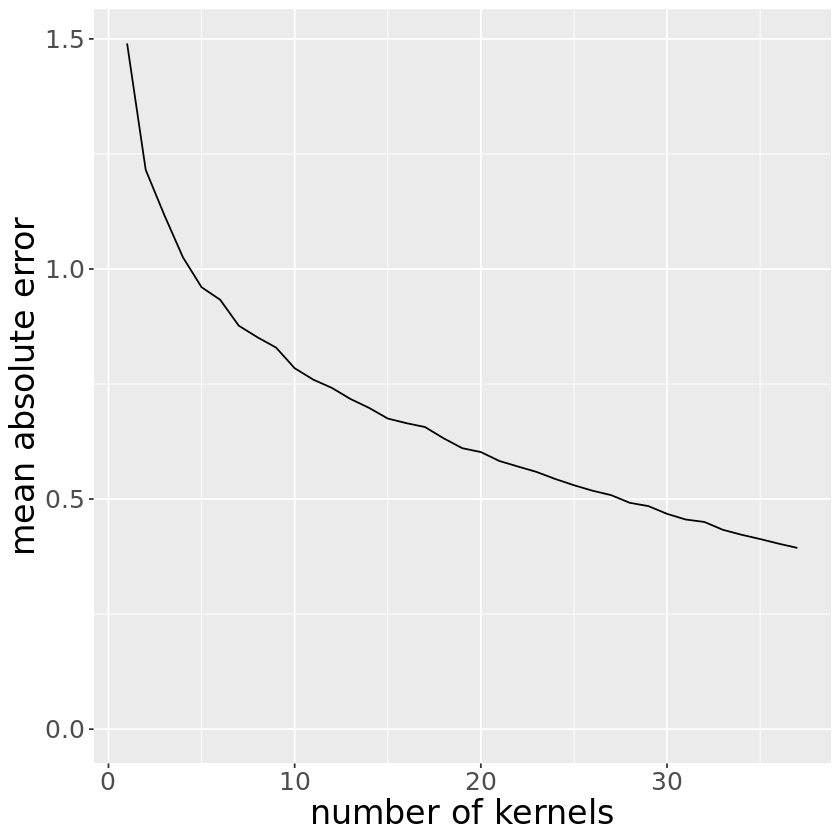

In [45]:
#<!-- see ../analysis_tools/suitable_kernel_counts.R for implementation -->
results <- read.table('./data/intermediate/rmse_vs_kernel_count.Rtable',header=TRUE, sep=" ")
ggplot(dat=results,aes(x=number.of.kernels,y=mae)) + geom_line() + labs(x="number of kernels",y="mean absolute error") + ylim(0,max(results$mae)) + theme(text = element_text(size=20),axis.text.x = element_text(size=15),axis.text.y = element_text(size=15))


The results presented in the Figure show the mean absolute error of models trained on varying numbers of kernels. As expected, the model fit improves with increasing number of kernels. In particular, larger improvements occur with each new kernel early in the series and tapers off as a new kernel is added to an already large number of kernels. The gradient is still significant until the largest number of samples examined (k = 37) suggesting that the model could benefit from additional training data. However, the model proposed is a proof of concept and suggests that a general purpose model is attainable and may not require many more kernels.

# Evaluation -- Predicted vs. measured execution time for all kernels

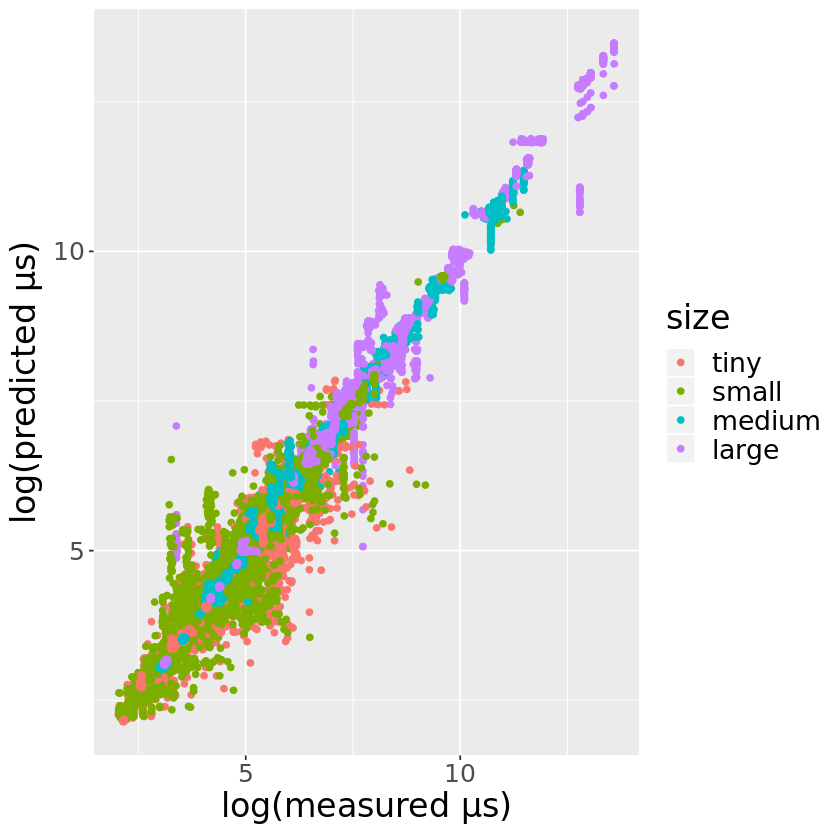

In [47]:
#generated with ../analysis_tools/sample_generator.R
load("./data/intermediate/full_dat.Rda")

#manually typecast integer variables
int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
num.inds <- lapply(full_dat, is.numeric)
num.inds <- as.logical(num.inds)

for (i in seq(along = num.inds)){
            feature.name = names(full_dat[i])
            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, full_dat[i] <- scale(full_dat[i]))
                                } #end i loop

#use 20% of data for training
sampled_indices <- sample(seq_len(nrow(full_dat)), size = round(nrow(full_dat)*0.2))
train_dat <- full_dat[sampled_indices, ]
test_dat <- full_dat[-sampled_indices, ]

#remove certain variables unavailable during real-world training
train_dat = subset(train_dat, select = -size)
train_dat = subset(train_dat, select = -application)
train_dat = subset(train_dat, select = -kernel)
train_dat = subset(train_dat, select = -total_time)

#build the model
rgd.aiwc <- ranger(log(kernel_time)~.,
                   data = train_dat,
                   num.trees = 505,
                   mtry = 30,
                   min.node.size = 9,
                   importance = "impurity",
                   splitrule = 'variance',
                   respect.unordered.factors = 'order')

#make the predictions
rgd.pred <- predict(rgd.aiwc,type='response',data=test_dat)

#plot the error
z <- data.frame(predicted=rgd.pred$predictions,
                actual=log(test_dat$kernel_time),
                device=test_dat$device,
                size=test_dat$size,
                kernel=test_dat$kernel)

#plot the difference in log(times)
ggplot(data=z,aes(x=actual,y=predicted,colour=size)) + geom_point() + labs(x=TeX("log(measured $\\mu$s)"),y=TeX("log(predicted $\\mu$s)"))+ theme(text = element_text(size=20),axis.text.x = element_text(size=15),axis.text.y = element_text(size=15))

#plot the absolute difference in times -- but I'd prefer to show this in the next section
#ggplot(data=z,aes(x=exp(actual),y=exp(predicted),colour=size)) + geom_point() + labs(x="predicted (us)",y="measured (us)")

#back up the predictions for the remainder of the paper
oz <- z

This Figure presents the measured kernel execution times against the predicted execution times from the trained model. Each point represents a single combination of kernel and problem size. The plot shows a strong linear correlation indicating a good model fit. Under-predictions typically occur on four kernels over the medium and large problem sizes, while over-predictions occur on the tiny and small problem sizes. However, these outliers are visually over-represented in this figure as the final mean absolute error is low, at ~0.11.

# Making Predictions --  Error in predicted execution time for each kernel invocation over four problem sizes

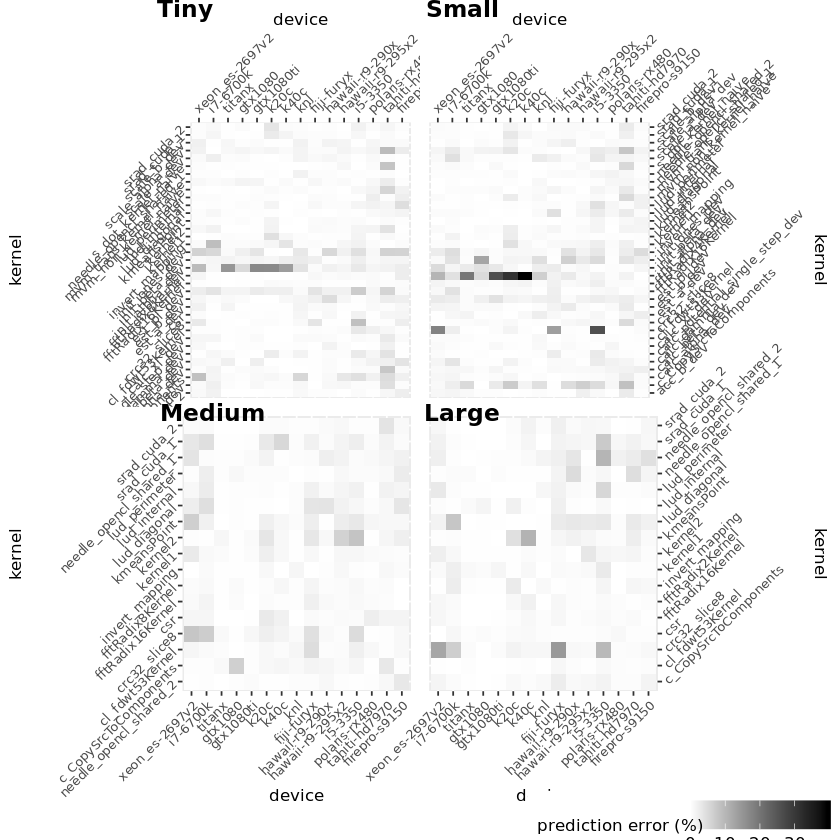

In [48]:
construct_percent_matrix <- function(data){
    x <- data
    m <- length(unique(x$kernel))
    n <- length(unique(x$device))
    y <- matrix(nrow=m,ncol=n,dimnames = list(unique(x$kernel),unique(x$device)))

    m_c <- 1
    for (i in unique(x$kernel)){
        n_c <- 1
        for (j in unique(x$device)){
            pred <- mean(subset(x,kernel==i&device==j)$predicted)
            meas <- mean(subset(x,kernel==i&device==j)$actual)
            y[m_c,n_c] <- abs(pred - meas) / meas * 100
            n_c <- n_c + 1
        }
        m_c <- m_c + 1
    }
    return (y)
}

z <- oz
total_percent <- data.frame()

for(sz in c('tiny','small','medium','large')){
    x <- subset(z,size==sz)
    hm_z <- construct_percent_matrix(x)
    my <- melt(hm_z)
    total_percent <- rbind(total_percent,my)

    #dirty hack to get plots the same size -- some label lengths are different so just get one label in the bottom plots to be as long
    #library(stringi)
    #max(stri_length(total_percent$Var1))
    ##30 is the longest string
    my$Var1 <- as.character(my$Var1)
    if(sz %in% c('tiny','medium'))
        my$Var1[which(my$Var1=="needle_opencl_shared_2")] <- "        needle_opencl_shared_2"
    else
        my$Var1[which(my$Var1=="needle_opencl_shared_2")] <- "needle_opencl_shared_2        "
    my$Var1 <- as.factor(my$Var1)

    assign(paste('my_',sz,sep=''),my)
}

for(sz in c('tiny','small','medium','large')){
    my <- eval(parse(text=paste('my_',sz,sep='')))
    p <- ggplot(data=my,aes(y=Var1,x=Var2,fill=value,label=value))
    p <- p + geom_tile()
    p <- p + scale_fill_continuous(high = "black", low = "white",limits=c(0, max(total_percent$value)))
    p <- p + labs(x='device',y='kernel',fill=TeX('prediction error ($\\%$)'))
    p <- p + theme(legend.position = "none",
                   axis.text.x = element_text(size = 8),
                   axis.text.y = element_text(size = 8,angle=45),
                   axis.title.x = element_text(size=10),
                   axis.title.y = element_text(size=10))

    if(sz == 'tiny')
        p <- p + scale_x_discrete(position = 'top') + theme(axis.text.x = element_text(angle = 45, hjust = 0, vjust=0))
    if(sz == 'small')
        p <- p + scale_y_discrete(position = 'right') + scale_x_discrete(position = 'top') + theme(axis.text.x = element_text(angle = 45, hjust = 0, vjust=0))
    if(sz == 'medium')
        p <- p + scale_y_discrete(position = 'left') + scale_x_discrete(position = 'bottom') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))
    if(sz == 'large')
        p <- p + scale_y_discrete(position = 'right') + scale_x_discrete(position = 'bottom') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))

    assign(paste('stacked_',sz,sep=''),p)
}

legend_generic <- get_legend(stacked_tiny + theme(legend.title=element_text(face="bold",size=10),
                                                  legend.text=element_text(size=10),
                                                  legend.position="bottom",
                                                  legend.justification="right",
                                                  legend.direction="horizontal"))
plots <- align_plots(stacked_tiny  ,
                     stacked_small ,
                     stacked_medium,
                     stacked_large)
                     #align="hv",axis="tblr")

xoff <- .22 # relative x position of label, within one plot
yoff <- .98 # relative y position of label, within one plot

x <- plot_grid(plot_grid(plots[[1]],plots[[2]],ncol=2,align="h")+draw_plot_label(label=c("Tiny",  "Small"),
                                                                                 x=c(0.22,0.55),
                                                                                 y=rep(1-(1-yoff),2),
                                                                                 hjust=.5, vjust=.5,
                                                                                 size=14),
               plot_grid(plots[[3]],plots[[4]],ncol=2,align="h")+draw_plot_label(label=c("       Medium",  "Large"),
                                                                                 x=c(0.22,0.55),
                                                                                 y=c(0.985,0.985),
                                                                                 hjust=.5, vjust=.5,
                                                                                 size=14),
               legend_generic,
               rel_heights=c(1,1,.065),
               nrow=3)
print(x)


In this section, we examine differences in accuracy of predicted execution times between different kernels, which is of importance if the predictions are to be used in a scheduling setting.
The four heat maps presented in the Figure show the difference between mean predicted and measured kernel execution times as a percentage of the measured time. Thus, they depict the relative error in prediction – lighter indicates a smaller error. Four different problem sizes are presented: tiny in the top-left, small in the top-right, medium bottom-left, large bottom-right.
In general, we see highly accurate predictions which on average differ from the measured experimental run- times by 1.1%, which correspond to actual execution time mispredictions of 8 μs to 1 secs according to problem size.
The init_alpha_dev kernel is the worst predicted kernel over both the tiny and small problem sizes, with mean misprediction at 7.3%. However, this kernel is only run once per application run – it is used in the initialization of the Hidden Markov Model – and as such there are fewer response variables available for model training.

# The benefits of this approach -- Mean measured kernel execution times compared against mean predicted kernel execution times to perform a selection of kernels on large problem sizes across 15 accelerator devices.

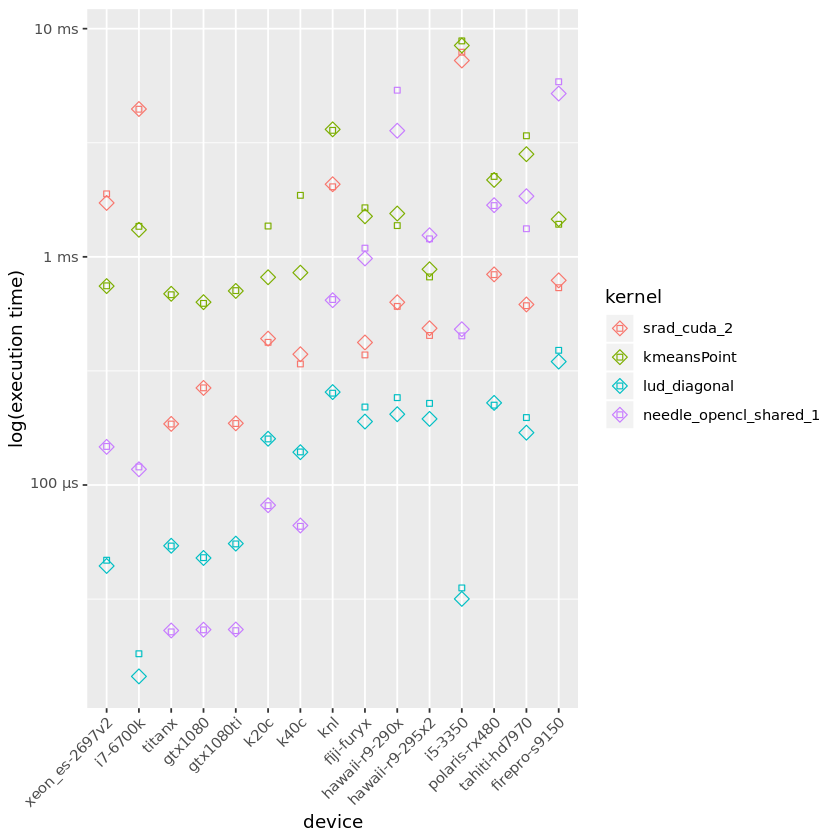

In [49]:
#generate predictions

motivating_df <- data.frame()
#NOTE: be sure to only use kernels with results for the specified problem size
featured_kernels <- c('srad_cuda_2',
                      'kmeansPoint',
                      'lud_diagonal',
#                      'fftRadix16Kernel',
                      'needle_opencl_shared_1')
featured_size <- c('large')
for(k in featured_kernels){
    for(d in unique(full_dat$device)){
        for(s in featured_size){
            zx <- subset(test_dat, kernel==k & device == d & size == s)
            rgd.pred <- predict(rgd.aiwc,type='response',data=zx)

            zy <- subset(full_dat, kernel==k & device == d & size == s)

            motivating_df <- rbind(motivating_df,
                                   data.frame('kernel'=k,
                                              'device'=d,
                                              'size'=s,
                                              'measured'=mean(zy$kernel_time)*0.001,
                                              'predicted'=mean(exp(rgd.pred$predictions))*0.001))
        }
    }
}

square <- 22
diamond<- 23
p <- ggplot(motivating_df,aes(x=device,y=measured,colour=kernel,shape=NA)) +
    geom_point(shape=square) +
    geom_point(aes(x=device,y=predicted,colour=kernel),shape=diamond, size=3) +
    theme(axis.text.x=element_text(angle=45,hjust=1)) +
    scale_y_log10(breaks=c(0.0001, 0.10, 1, 10),labels=c("100 ns",TeX("100 $\\mu s$"),"1 ms", "10 ms")) +
    labs(y="log(execution time)",x="device",colour="kernel",shape="type")
print(p)


To demonstrate the utility of the trained model to guide scheduling choices, we focus on the accuracy of performance time prediction of individual kernels over all devices. The model performance in terms of real execution times is presented for four randomly selected kernels in the Figure. The shape denotes the type of execution time data point, a square indicates the mean measured time, and the diamond indicates the mean predicted time. Thus, a perfect prediction occurs where the measured time – square – fits perfectly within the predicted – diamond – as seen in the legend.
The purpose of showing these results is to highlight the set- ting in which they could be used – on the supercomputing node. In this instance, it is expected a node to be composed of any combination of the 15 devices presented in the Figure 6. Thus, to be able to advise a scheduler which device to use to execute a kernel, the model must be able to correctly predict on which of a given pair of devices the kernel will run fastest. For any selected pair of devices, if the relative ordering of the measured and predicted execution times is different, the scheduler would choose the wrong device. In almost all cases, the relative order is preserved using our model. In other words, our model will correctly predict the fastest device in all cases – with one exception, the kmeansPoint kernel. For this kernel, the predicted time of the fiji-furyx is lower than the hawaii-r9-290x, however the measured times between the two shows the furyx completing the task in a shorter time. For all other device pairs, the relative order for the kmeansPoint kernel is correct. Additionally, the lud_diagonal kernel suffers from systematic under-prediction of execution times on AMD GPU devices, however the relative ordering is still correct. As such, the proposed model provides sufficiently accurate execution time predictions to be useful for scheduling to heterogeneous compute devices on supercomputers.